GAN implementation on CelebA dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_dir = '/content/drive/MyDrive/processed-celeba-small.zip (Unzipped Files)/processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
#import problem_unittests as tests
#import helper

%matplotlib inline

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
def get_dataloader(batch_size, image_size, data_dir='/content/drive/MyDrive/processed-celeba-small.zip (Unzipped Files)/processed_celeba_small/'):
    
    # image resisize and normalize as per tensor
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])

    dataset = datasets.ImageFolder(data_dir, transform)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = 4)

    return data_loader

In [ ]:
# Hyperparameters for data loader
batch_size = 32
img_size = 32
celeba_train_loader = get_dataloader(batch_size, img_size) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


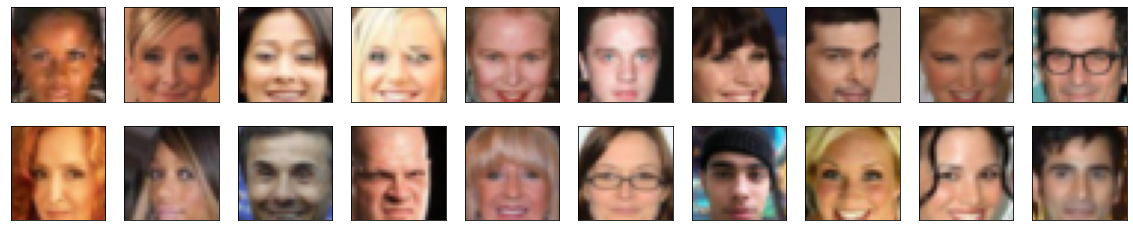

In [ ]:
# Function to displaye the celebA images from the training data
def show_images(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#iterate the data loader to fetch individual image
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

fig = plt.figure(figsize=(20, 4))
num_of_img=20
for idx in np.arange(num_of_img):
    ax = fig.add_subplot(2, num_of_img/2, idx+1, xticks=[], yticks=[])
    show_images(images[idx])

In [ ]:
# This function will scale the image in the range of -1 to 1 for easy 
#computation. This is important because tanh activation is used which has values ranging between -1 to 1. 
def scale(x):
    feature_range = (-1, 1)
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [ ]:
 # checking scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

"\nprint('Min: ', scaled_img.min())\nprint('Max: ', scaled_img.max())\n\n"

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#Convolution layer function for the discriminator
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, norm=True):

    conv_layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    conv_layers.append(conv_layer)
    if norm:
        conv_layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*conv_layers)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):

        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        
        self.leaky_relu_slope = 0.2

        #First layer with input size equal to the image size
        self.conv1 = conv(3, conv_dim, norm=False) 
        #Second layer in which the size is reduced to 8x8 
        self.conv2 = conv(conv_dim, conv_dim*2)       
        #Third layer in which the size is reduced to 4x4 
        self.conv3 = conv(conv_dim*2, conv_dim*4)         
                
        #Final classification fully connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
    
    
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), self.leaky_relu_slope)
        out = F.leaky_relu(self.conv2(out), self.leaky_relu_slope)
        out = F.leaky_relu(self.conv3(out), self.leaky_relu_slope)
        
        #flattening: output is converted into the single stream of data
        out = out.view(-1, self.conv_dim*4*4*4) 

        out = self.fc(out) 
        
        return out

### 2) Generator

In [ ]:
#Deconvolution layer funtion to generate deconvolutional layers for the Generator
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, norm=True):

    de_conv_layers = []
    
    # without bias transpose convolutional layer appended
    de_conv_layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    
    if norm:
        de_conv_layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*de_conv_layers)

## Generator Model

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim_depth):

        super(Generator, self).__init__()
        
        self.conv_dim_depth = conv_dim_depth
        
        self.fc = nn.Linear(z_size, conv_dim_depth*4*4*4)

        
        # transpose conv layers

        # These layers works exactly opposite as that of the layers in discriminator
        # Input from latent is enlarged to match the size of an imagein each decovolutional layer
        self.deconv1 = deconv(conv_dim_depth*4, conv_dim_depth*2)
        self.deconv2 = deconv(conv_dim_depth*2, conv_dim_depth)
        self.deconv3 = deconv(conv_dim_depth, 3, norm=False)


    def forward(self, x):
  
        x = self.fc(x)
        batch_size = x.shape[0]

        x = x.view(-1, self.conv_dim_depth*4, 4, 4)
                
        # hidden transpose conv layers + relu
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        
        # last layer + tanh activation
        x = self.deconv3(x)
        x = torch.tanh(x)
            
        return x

**Initialize the weights**

All weights were Normal distributed with standard deviation 0.02.

In [ ]:
# Funtion assigns initial weights in the network
def weights_init_normal(m):

    classname = m.__class__.__name__
        
    if classname.find('Linear') != -1 or classname.find('Convo2d') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)        
        m.bias.data.fill_(0)

Building the Descriminator and Generator network

In [ ]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    D = Discriminator(d_conv_dim)                             #Discriminator
    G = Generator(z_size=z_size, conv_dim_depth=g_conv_dim)   #Generator

    #applying the initial weights to the networks
    D.apply(weights_init_normal) 
    G.apply(weights_init_normal)
    
    return D, G
    

In [ ]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100 #latent size

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

#print(D)
#print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

**Training on GPU**

In [ ]:
import torch

# Check for a GPU to run the code
# If GPU not found then the message will be displayed to the user
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


**Discriminator & Generator Losses**

In [ ]:
def real_loss(Disc_out, smooth=False):
    batch_size = Disc_out.size(0)

    labels = torch.ones(batch_size)    # real labels = 1
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()  #Binary Cross entropy logits loss
    calculated_loss = criterion(Disc_out.squeeze(), labels)    
    return calculated_loss

def fake_loss(Disc_out):
    batch_size = Disc_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()

    # calculate loss
    calculated_loss = criterion(Disc_out.squeeze(), labels)
    
    return calculated_loss

## Optimizers

In [ ]:
import torch.optim as optim

lr = 0.005
beta1 = 0.3
beta2 = 0.999 # default value
#Adam Optimizer for Discriminator 
d_optimizer = optim.Adam(D.parameters(), lr, betas=(beta1, beta2))  

#Adam Optimizer for Generator
g_optimizer = optim.Adam(G.parameters(), lr, betas=(beta1, beta2))  

## Training

In [ ]:
# In each epoch decriminator will be feeded with the input images and the images generated by the Generator
def train(D, G, no_epochs, print_every=2500):
    
    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []

    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(no_epochs):

        #training the batch
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)  # Generator fake images
            
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
                
             
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)

            D_fake = D(fake_images) #fake images passed to the discriminator
            
            g_loss = real_loss(D_fake) 
            
            g_loss.backward()
            g_optimizer.step()
            
            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, no_epochs, d_loss.item(), g_loss.item()))

        G.eval() 
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

    with open('fake_train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses

In [ ]:
# set number of epochs 
no_epochs = 25

# call training function
losses = train(D, G, no_epochs = no_epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [    1/   25] | d_loss: 1.4368 | g_loss: 6.1957
Epoch [    1/   25] | d_loss: 1.1785 | g_loss: 0.9907
Epoch [    2/   25] | d_loss: 1.1411 | g_loss: 1.0595
Epoch [    2/   25] | d_loss: 1.2112 | g_loss: 1.7577
Epoch [    3/   25] | d_loss: 1.8337 | g_loss: 2.4399
Epoch [    3/   25] | d_loss: 0.9765 | g_loss: 1.4300
Epoch [    4/   25] | d_loss: 1.3509 | g_loss: 2.3603
Epoch [    4/   25] | d_loss: 0.7973 | g_loss: 2.1470
Epoch [    5/   25] | d_loss: 0.8940 | g_loss: 1.7903
Epoch [    5/   25] | d_loss: 0.9353 | g_loss: 3.6720
Epoch [    6/   25] | d_loss: 0.6641 | g_loss: 2.2729
Epoch [    6/   25] | d_loss: 0.8083 | g_loss: 1.3226
Epoch [    7/   25] | d_loss: 0.6312 | g_loss: 2.7345
Epoch [    7/   25] | d_loss: 0.4102 | g_loss: 2.9844
Epoch [    8/   25] | d_loss: 1.9143 | g_loss: 4.5014
Epoch [    8/   25] | d_loss: 1.5547 | g_loss: 5.1833
Epoch [    9/   25] | d_loss: 0.7919 | g_loss: 5.8245
Epoch [    9/   25] | d_loss: 1.1166 | g_loss: 3.9151
Epoch [   10/   25] | d_loss

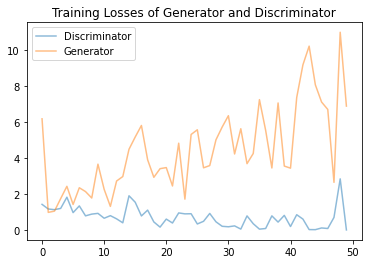

In [ ]:
# It will plot the Descriminator and Generator losses
fig, ax = plt.subplots()
G_D_losses = np.array(losses)
plt.plot(G_D_losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(G_D_losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses of Generator and Discriminator")
plt.legend()

## Samples from Generator

In [ ]:
# This function will displaye the images generated by the Generator
def show_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
# Load samples from generator, taken while training
with open('fake_train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

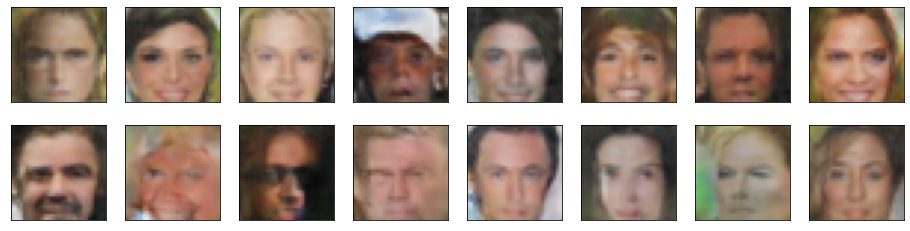

In [ ]:
_ = show_samples(-1, samples)

# End of the Notebook